# Temperature/Heat budget in the subpolar North Atlantic (SPNA)

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
%matplotlib inline

### Load dataset

In [2]:
ds = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_budgets').sel(face=[2,10])

In [3]:
# Remove unused variables
ds = ds.drop(['tendV','forcV','hConvV','vConvV','tendS','forcS','adv_hConvS','adv_vConvS','dif_hConvS','dif_vConvS',
              'tendSln','forcSln','adv_hConvSln','adv_vConvSln','dif_hConvSln','dif_vConvSln'])

In [4]:
THETA = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output').THETA.sel(face=[2,10])

### Volume

In [5]:
# Volume (m^3)
vol = (ds.rA*ds.drF*ds.hFacC).transpose('face','k','j','i')

### Subselect data

In [6]:
# Define spatial boundaries of the SPNA
patch_lats = [46, 65, 65, 46]
patch_lons = [-95, -95, 10, 10]

In [7]:
ds = ds.where((ds.XC>=np.min(patch_lons))&(ds.XC<=np.max(patch_lons))&\
              (ds.YC>=np.min(patch_lats))&(ds.YC<=np.max(patch_lats))).isel(time=slice(1, -1))

In [8]:
vol = vol.where((ds.XC>=np.min(patch_lons))&(ds.XC<=np.max(patch_lons))&\
                (ds.YC>=np.min(patch_lats))&(ds.YC<=np.max(patch_lats)))

### Map

In [9]:
face02 = THETA.sel(face=2)
face10 = THETA.sel(face=10)

In [10]:
# rotate faces to easy plot the merged array
face10.values = np.rot90(face10.values, axes=(2, 3))

# fix X,Y coordinates
face10.XC.values = np.rot90(face10.XC.values)
face10.YC.values = np.rot90(face10.YC.values)

In [11]:
# merge faces
face10.i.values = np.array(range(0,90))
face02.i.values = np.array(range(90,180))

faces = xr.concat([face10,face02], dim='i')

In [12]:
sst_mean = faces[:,0].mean('time')

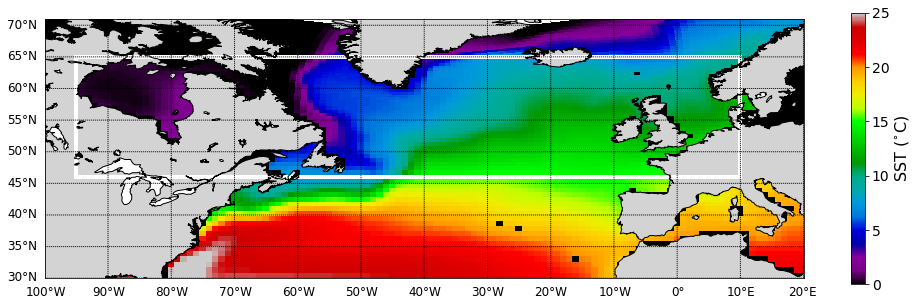

In [13]:
fig = plt.figure(figsize=(17,5))

m = Basemap(projection='cyl', llcrnrlat=30,urcrnrlat=71, llcrnrlon=-100, urcrnrlon=20,lat_ts=0,resolution='l')

m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-60,80,5),labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(0,360,10),labels=[0,0,0,1],fontsize=12)
p = m.pcolormesh(sst_mean.XC.values,sst_mean.YC.values,np.ma.masked_invalid(sst_mean.values),
                 vmin=0,vmax=25,cmap='nipy_spectral')

# Polygon
x, y = m(patch_lons, patch_lats)
#xy is a numpy array with shape Nx2.
xy = np.zeros(shape=(len(x),2))
xy[:,0] = x
xy[:,1] = y
patch = Polygon(xy, fc='None', ec='w', linewidth=4, linestyle='-')
plt.gca().add_patch(patch)

cb = fig.colorbar(p,ticks=np.arange(0,30,5))
cb.set_label(r'SST ($^{\circ}$C)',fontsize=16)
cb.ax.tick_params(labelsize=14)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Total convergences and tendency

In [14]:
# Total convergence of advective flux
adv_ConvH = ds.adv_hConvH + ds.adv_vConvH

# Total convergence of diffusive flux
dif_ConvH = ds.dif_hConvH + ds.dif_vConvH

# Total convergence
ConvH = adv_ConvH + dif_ConvH

# Total tendency
totalH = ConvH + ds.forcH

### Sum over entire SPNA

In [15]:
tendH_spna = (ds.tendH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
forcH_spna = (ds.forcH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
adv_ConvH_spna = (adv_ConvH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
dif_ConvH_spna = (dif_ConvH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
ConvH_spna = (ConvH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
totalH_spna = (totalH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])

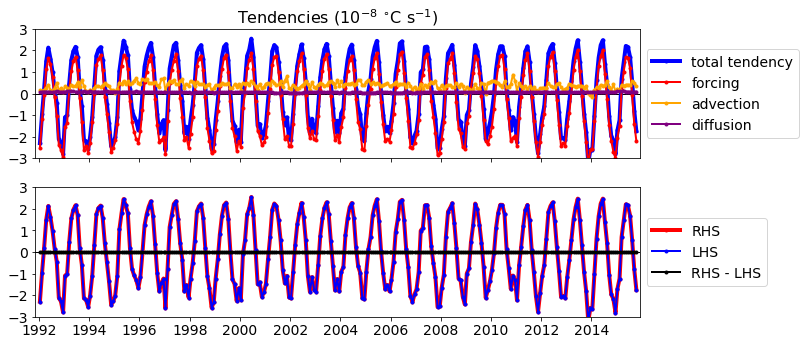

In [16]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title(r'Tendencies (10$^{-8}$ $^{\circ}$C s$^{-1}$)',fontsize=16)

plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendH_spna.time, tendH_spna*1e8, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH_spna.time, forcH_spna*1e8, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH_spna.time, adv_ConvH_spna*1e8, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH_spna.time, dif_ConvH_spna*1e8, lw=2, color='purple', marker='.',label='diffusion')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-3, 3])
plt.yticks(np.arange(-3,4,1.0),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalH_spna.time, totalH_spna*1e8, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH_spna.time, tendH_spna*1e8, lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendH_spna.time, (totalH_spna-tendH_spna)*1e8, lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-3, 3])
plt.yticks(np.arange(-3,4,1.0),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

fig.subplots_adjust(left=0.1, right=0.80, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Integrate over time and convert to heat content

In [17]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

In [18]:
H_tnd = (tendH_spna*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_tot = (totalH_spna*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_frc = (forcH_spna*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_adv = (adv_ConvH_spna*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_dif = (dif_ConvH_spna*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])

In [19]:
results = dask.compute(H_tnd, H_frc, H_adv, H_dif, H_tot)

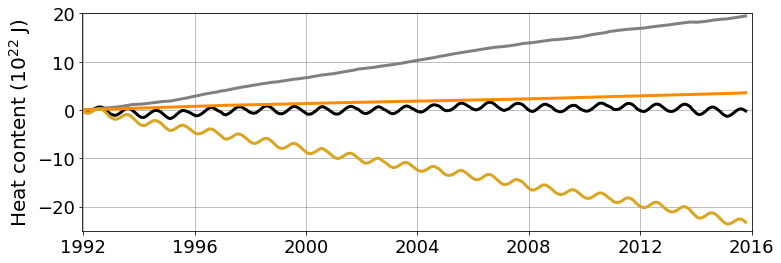

In [20]:
plt.figure(figsize=(12,4))

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(results[0].time, results[0]*1e-22, lw=3, color='black',label='total')
plt.plot(results[2].time, results[2]*1e-22, lw=3, color='grey',label='advection')
plt.plot(results[3].time, results[3]*1e-22, lw=3, color='darkorange',label='diffusion')
plt.plot(results[1].time, results[1]*1e-22, lw=3, color='goldenrod',label='forcing')

plt.xlim(['1992-01-15','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2020-01-15',freq='48M'),fontsize=18)
plt.ylim([-25, 20])
plt.yticks(np.arange(-20,30,10),fontsize=18)
plt.ylabel('Heat content (10$^{22}$ J)',fontsize=20)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Detrend

In [21]:
H_tnd = xr.DataArray(signal.detrend(results[0]),coords=[results[0].time],dims=['time'])
H_frc = xr.DataArray(signal.detrend(results[1]),coords=[results[1].time],dims=['time'])
H_adv = xr.DataArray(signal.detrend(results[2]),coords=[results[2].time],dims=['time'])
H_dif = xr.DataArray(signal.detrend(results[3]),coords=[results[3].time],dims=['time'])
H_tot = xr.DataArray(signal.detrend(results[4]),coords=[results[4].time],dims=['time'])

In [22]:
results = dask.compute(H_tnd, H_frc, H_adv, H_dif, H_tot)

### Seasonal anomaly

In [23]:
H_tnd = results[0].groupby('time.month') - results[0].groupby('time.month').mean('time')
H_frc = results[1].groupby('time.month') - results[1].groupby('time.month').mean('time')
H_adv = results[2].groupby('time.month') - results[2].groupby('time.month').mean('time')
H_dif = results[3].groupby('time.month') - results[3].groupby('time.month').mean('time')
H_tot = results[4].groupby('time.month') - results[4].groupby('time.month').mean('time')

- $\mathcal{T}$: Total ocean heat content
- $\mathcal{A}$: Advective heat convergence
- $\mathcal{M}$: Diffusive heat convergence
- $\mathcal{F}$: Forcing

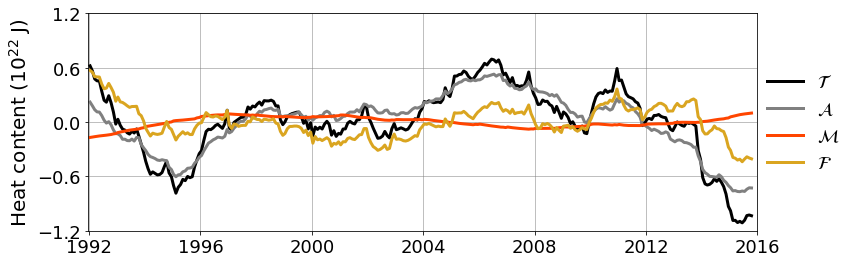

In [24]:
plt.figure(figsize=(12,4))

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(H_tnd.time, H_tnd*1e-22, lw=3, color='black',label=r'$\mathcal{T}$')
plt.plot(H_adv.time, H_adv*1e-22, lw=3, color='grey',label=r'$\mathcal{A}$')
plt.plot(H_dif.time, H_dif*1e-22, lw=3, color='orangered',label=r'$\mathcal{M}$')
plt.plot(H_frc.time, H_frc*1e-22, lw=3, color='goldenrod',label=r'$\mathcal{F}$')

plt.xlim(['1992-01-15','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2020-01-15',freq='48M'),fontsize=18)
plt.ylim([-1.2, 1.2])
plt.yticks(np.arange(-1.2,1.8,0.6),fontsize=18)
plt.ylabel('Heat content (10$^{22}$ J)',fontsize=20)
plt.legend(loc='upper left',bbox_to_anchor=(0.99, 0.8),frameon=False,fontsize=18)

plt.savefig('/rigel/home/jt2796/figure.pdf')
plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Compare integrated tendency with `THETA`

In [28]:
H_spna = (tendH_spna*ds.dt).cumsum(dim='time')

In [29]:
THETA = THETA.where((ds.XC>=np.min(patch_lons))&(ds.XC<=np.max(patch_lons))&\
                    (ds.YC>=np.min(patch_lats))&(ds.YC<=np.max(patch_lats))).transpose('time','face','k','j','i')
THETA_spna = (THETA*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
THETA_spna = THETA_spna - THETA_spna.mean('time')

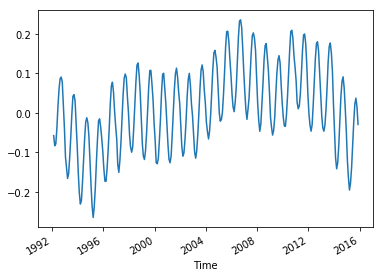

In [30]:
H_spna.plot()

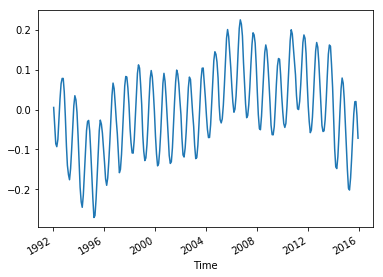

In [31]:
THETA_spna.plot()

## Calculate anomalies before integration

In [26]:
# Mean (climatology)
ds_clim = ds.groupby('time.month').mean('time')

In [27]:
# Anomaly
ds_anom = ds.groupby('time.month') - ds_clim

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/xarray/core/indexing.py:1168: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


### Total convergences and tendency

In [32]:
# Total convergence of advective flux
adv_ConvH = ds_anom.adv_hConvH + ds_anom.adv_vConvH

# Total convergence of diffusive flux
dif_ConvH = ds_anom.dif_hConvH + ds_anom.dif_vConvH

# Total convergence
ConvH = adv_ConvH + dif_ConvH

# Total tendency
totalH = ConvH + ds_anom.forcH

### Sum over entire SPNA

In [33]:
tendH_spna = (ds_anom.tendH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
forcH_spna = (ds_anom.forcH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
adv_ConvH_spna = (adv_ConvH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
dif_ConvH_spna = (dif_ConvH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
ConvH_spna = (ConvH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
totalH_spna = (totalH*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])

/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


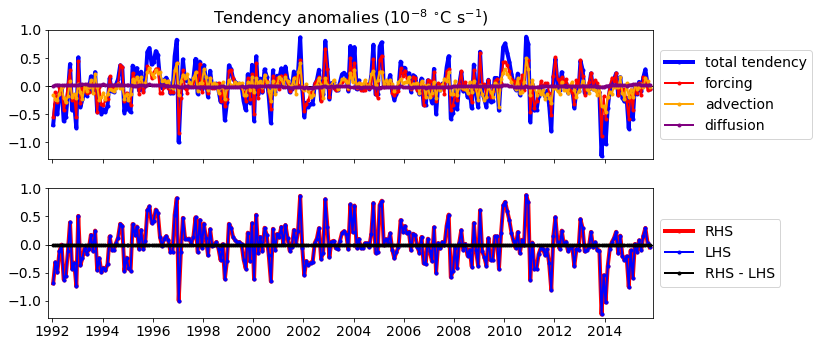

In [34]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title(r'Tendency anomalies (10$^{-8}$ $^{\circ}$C s$^{-1}$)',fontsize=16)

plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendH_spna.time, tendH_spna*1e8, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH_spna.time, forcH_spna*1e8, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH_spna.time, adv_ConvH_spna*1e8, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH_spna.time, dif_ConvH_spna*1e8, lw=2, color='purple', marker='.',label='diffusion')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-1.3, 1.0])
plt.yticks(np.arange(-1.0,1.5,0.5),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalH_spna.time, totalH_spna*1e8, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH_spna.time, tendH_spna*1e8, lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendH_spna.time, (totalH_spna-tendH_spna)*1e8, lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-1.3, 1.0])
plt.yticks(np.arange(-1.0,1.5,0.5),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

fig.subplots_adjust(left=0.1, right=0.80, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Integrate over time

In [37]:
results = dask.compute(tendH_spna, forcH_spna, adv_ConvH_spna, dif_ConvH_spna, totalH_spna)

/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [38]:
H_tnd = (results[0]*ds.dt).cumsum(dim='time')
H_tot = (results[4]*ds.dt).cumsum(dim='time')
H_frc = (results[1]*ds.dt).cumsum(dim='time')
H_adv = (results[2]*ds.dt).cumsum(dim='time')
H_dif = (results[3]*ds.dt).cumsum(dim='time')

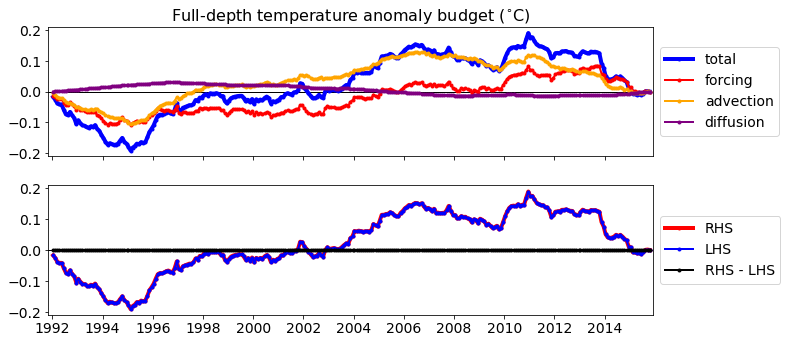

In [39]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title(r'Full-depth temperature anomaly budget ($^{\circ}$C)',fontsize=16)

plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(H_tnd.time, H_tnd, lw=4, color='blue', marker='.',label='total')
plt.plot(H_frc.time, H_frc, lw=2, color='red', marker='.',label='forcing')
plt.plot(H_adv.time, H_adv, lw=2, color='orange', marker='.',label='advection')
plt.plot(H_dif.time, H_dif, lw=2, color='purple', marker='.',label='diffusion')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-0.21, 0.21])
plt.yticks(np.arange(-0.2,0.3,0.1),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(H_tnd.time, H_tot, lw=4, color='red', marker='.',label='RHS')
plt.plot(H_tot.time, H_tnd, lw=2, color='blue', marker='.',label='LHS')
plt.plot(H_tnd.time, H_tot-H_tnd, lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-0.21, 0.21])
plt.yticks(np.arange(-0.2,0.3,0.1),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

fig.subplots_adjust(left=0.1, right=0.80, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Integrate over time and convert to heat content

In [40]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

In [41]:
H_tnd = (results[0]*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_tot = (results[4]*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_frc = (results[1]*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_adv = (results[2]*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_dif = (results[3]*ds.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])

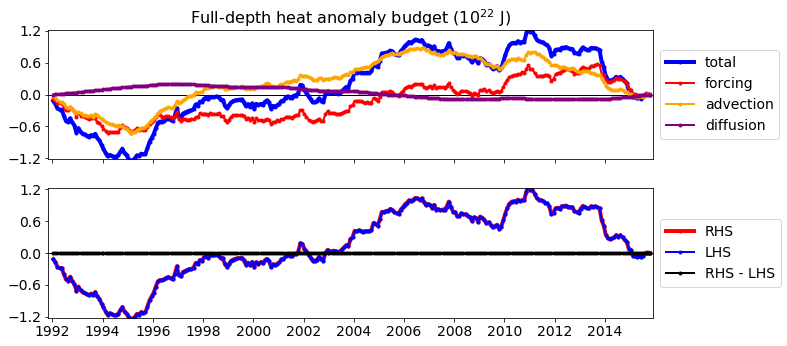

In [42]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title(r'Full-depth heat anomaly budget (10$^{22}$ J)',fontsize=16)

plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(H_tnd.time, H_tnd*1e-22, lw=4, color='blue', marker='.',label='total')
plt.plot(H_frc.time, H_frc*1e-22, lw=2, color='red', marker='.',label='forcing')
plt.plot(H_adv.time, H_adv*1e-22, lw=2, color='orange', marker='.',label='advection')
plt.plot(H_dif.time, H_dif*1e-22, lw=2, color='purple', marker='.',label='diffusion')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
plt.ylim([-1.22, 1.22])
plt.yticks(np.arange(-1.2,1.8,0.6),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(H_tnd.time, H_tot*1e-22, lw=4, color='red', marker='.',label='RHS')
plt.plot(H_tot.time, H_tnd*1e-22, lw=2, color='blue', marker='.',label='LHS')
plt.plot(H_tnd.time, (H_tot-H_tnd)*1e-22, lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.ylim([-1.22, 1.22])
plt.yticks(np.arange(-1.2,1.8,0.6),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

fig.subplots_adjust(left=0.1, right=0.80, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

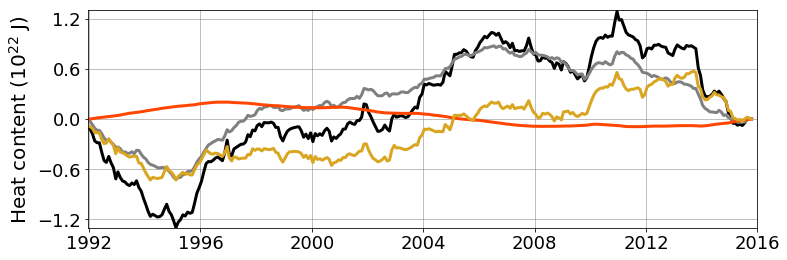

In [45]:
plt.figure(figsize=(12,4))

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(H_tnd.time, H_tnd*1e-22, lw=3, color='black',label='Total')
plt.plot(H_adv.time, H_adv*1e-22, lw=3, color='grey',label='Advective heat convergence')
plt.plot(H_dif.time, H_dif*1e-22, lw=3, color='orangered',label='Diffusive heat convergence')
plt.plot(H_frc.time, H_frc*1e-22, lw=3, color='goldenrod',label='Forcing')

plt.xlim(['1992-01-15','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2020-01-15',freq='48M'),fontsize=18)
plt.ylim([-1.3, 1.3])
plt.yticks(np.arange(-1.2,1.8,0.6),fontsize=18)
plt.ylabel('Heat content (10$^{22}$ J)',fontsize=20)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()